In [1]:
# test improvement on filtered dataset
# do not search for keyword
# apply news_filter

# import necessary items
# mostly copied over from MM_Covid_Explain2.ipynb
# commented some stuff out that I couldn't install
# but that also didn't seem to be needed
import re
# import simdjson as sj
# import gzip
# from tqdm import tqdm
import pandas as pd
# from tqdm.notebook import tqdm
import swifter
# import seaborn as sns
import numpy as np	
# from nltk import sent_tokenize
# from sentence_transformers import SentenceTransformer
# from wutils.general import save_pickle, load_pickle
from wutils.mat import MarkedMatrix
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from treeinterpreter import treeinterpreter as ti
# used to time certain functions that take a long time
# not really needed, but somewhat interesting
import time
# for plotting
import matplotlib.pyplot as plt
# for saving data to a pickle
import pickle

In [2]:
# load cord-19 (reference) data from pickle
# changed from ./pickles/who_cord_df.pkl to ./pickles/newest_cord_df_ft.pkl
# changed from load_pickle to pd.read_pickle
# this gets rid of an error I've been having
start = time.time()
cord_df = pd.read_pickle('./pickles/newest_cord_df_ft.pkl')
end = time.time()
print('seconds: ', end - start)

seconds:  66.78718519210815


In [3]:
# load good (true) data from pickle
# changed from ./pickles/newest_good_sample_df_ft.pkl to clean_good_df.pkl
# also changed from load_pickle to pd.read_pickle
# thanks, stackoverflow!
start = time.time()
good_df = pd.read_pickle('./pickles/clean_good_df.pkl')
end = time.time()
print('seconds: ', end - start)

seconds:  62.608518838882446


In [4]:
# load bad (false) data from pickle
# changed from ./pickles/newest_bad_df_ft.pkl to cleab_bad_df.pkl
# changed from load_pickle to pd.read_pickle
start = time.time()
bad_df = pd.read_pickle('./pickles/clean_bad_df.pkl')
end = time.time()
print('seconds: ', end - start)

seconds:  7.36466121673584


In [5]:
# example of good article
good_df[good_df.cleanText.swifter.apply(lambda x: 'Virus-ridden particles are inhaled by others and come into contact with cells' in x)]

Pandas Apply:   0%|          | 0/97539 [00:00<?, ?it/s]

,authors,publishDate,cleanText,title,url,covidFreq,sentences,fixed_sent,sent_embeddings,ft_embeddings,mean_embed,hostname,ft_has_nan
1206633,[Robin Mckie],2020-04-24 00:00:00,But their impact has been mild compared with t...,Coronavirus: what have scientists learned abou...,https://www.theguardian.com/world/2020/apr/24/...,13,[But their impact has been mild compared with ...,[But their impact has been mild compared with ...,"[[-0.15770671, -1.8202316, 0.33610916, -0.9967...","[[-0.020828864, 0.004317664, 0.000431179, 0.04...","[-0.007586088, -0.021697361, 0.0035677361, 0.0...",www.theguardian.com,False


In [6]:
# function to parse urls
import urllib.parse

def get_hostname(url):
    o = urllib.parse.urlsplit(url)
    return o.hostname

In [7]:
# function that returns true if text has to do with keep_if (wuhan in this case)
# returns false if text contains words in blacklist
# if text contains words from neither, defaults to true
def news_filter(text):
    keep_if = ['wuhan']
    text = text.lower()
    blacklist = ['u.s.', 'america', 'korea', 'china', 'mexico', 'australia', 'uk', 'u.k.', 'new york', 'los angeles', 'nfl', 'nba', 'mlb', 'epl']
    if any(x in text for x in keep_if):
        return True
    if any(x in text for x in blacklist):
        return False
    return True

In [8]:
# not really sure what any of the below does to be honest
# I assume it has to do with preparing the data somehow
good_df['hostname'] = good_df['url'].swifter.apply(get_hostname)
bad_df['hostname'] = bad_df['url'].swifter.apply(get_hostname)

Pandas Apply:   0%|          | 0/97539 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21135 [00:00<?, ?it/s]

In [9]:
good_df['mean_embed'] = good_df['sent_embeddings'].swifter.apply(lambda x: x.mean(axis=0))
bad_df['mean_embed'] = bad_df['sent_embeddings'].swifter.apply(lambda x: x.mean(axis=0))

Pandas Apply:   0%|          | 0/97539 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21135 [00:00<?, ?it/s]

In [10]:
# seems that we are keeping the bad articles only if they have this "is ap" quality
# I'm not sure what "is ap" means, but that's what this function does
is_AP = bad_df['cleanText'].swifter.apply(lambda x: '(AP)' in x)
print('Found: ', is_AP.sum())
bad_df = bad_df[~is_AP]

Pandas Apply:   0%|          | 0/21135 [00:00<?, ?it/s]

Found:  6268


In [11]:
# keyword
# KW = 'transmission'

In [12]:
# dataset
dataset = 'filtered'

In [13]:
# don't know what this does
# more data prep I guess
cord_df = cord_df.dropna()
cord_df['mean_embed'] = cord_df['sent_embeddings'].swifter.apply(lambda x: x.mean(axis=0))

Pandas Apply:   0%|          | 0/10149 [00:00<?, ?it/s]

In [14]:
# filtering dataframe to look for the keyword
# don't know why will named this "has_vax" if the keyword is transmission
# but I won't question it
# has_vax = cord_df[cord_df.title.swifter.apply(lambda x: KW in x.lower()) | cord_df.abstract.swifter.apply(lambda x: KW in x.lower())]

# vax_ref = np.vstack(has_vax['mean_embed'])
vax_ref = np.vstack(cord_df['mean_embed'])

## From the paper:

"We extract only articles that contain the word “transmission” and name it the “transmission news” dataset. The purpose ... is to provide a smaller sample with articles focusing more on attributes of the virus rather than on other topics."

The results for these smaller more specific datasets differs from the overall dataset as well, with the transmission news dataset seeming to fare a little bit worse than the other ones.

To show the effectiveness of his algorithm, Will is choosing to use the *"transmission news"* dataset. 

![table1](../../table_1.png)

In [15]:
# will commented this out
# vax_good_df = good_df[good_df['cleanText'].swifter.apply(lambda x: KW in x.lower())]
# vax_bad_df = bad_df[bad_df['cleanText'].swifter.apply(lambda x: KW in x.lower())]

# creating dataframes and cleaning them up
vax_good_df = good_df
vax_bad_df = bad_df

# applying news filter function:
# (removing text containing unwanted keywords, unless they also contain other wanted keywords)
vax_good_df = vax_good_df[vax_good_df['cleanText'].swifter.apply(news_filter)]
vax_bad_df = vax_bad_df[vax_bad_df['cleanText'].swifter.apply(news_filter)]

# turning this into a matrix I think
vax_good_mat = np.vstack(vax_good_df.mean_embed)
vax_bad_mat = np.vstack(vax_bad_df.mean_embed)

# turning matrix into a marked matrix (matrix with labels)
# will's own personal python library actually, impressive
# we don't want to use this vax_raw_mm
# it gives us weird results
# vax_raw_mm = MarkedMatrix([('good', vax_good_mat), ('bad', vax_bad_mat)])

Pandas Apply:   0%|          | 0/97539 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14867 [00:00<?, ?it/s]

In [16]:
# will calculates the distances between reference dataframe and to-be-labeled dataframe here I am assuming
# below is a link to possible other metrics to use besides cosine
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

# vgood2ref is the distance between vax_good_mat and vax_ref
start = time.time()
vgood2ref = cdist(vax_good_mat, vax_ref, 'cosine')
print('done w/ good')
end = time.time()
print('seconds: ', end-start)

# vbad2ref is the distance between vax_bad_mat and vax_ref
start = time.time()
vbad2ref = cdist(vax_bad_mat, vax_ref, 'cosine')
print('done w/ bad')
end = time.time()
print('seconds: ', end-start)

# turning this into a marked matrix
vax_mm = MarkedMatrix([('good', vgood2ref), ('bad', vbad2ref)])

# theoretically, vgood2ref should contain small distances (since good articles should be similar to CORD-19)
# and vbad2ref should contain large distances (since bad articles should not be similar to CORD-19)

done w/ good
seconds:  236.31787514686584
done w/ bad
seconds:  51.746947050094604


In [17]:
# Alt method
# commented out by Will originally
# has_vax = cord_df.sample(5000)
# vax_ref = np.vstack(has_vax['mean_embed'])

In [18]:
# War on Terror Cells: Strategies to Eradicate "Novel Coronavirus" Effectively
np.where(~np.isfinite(vax_ref))

(array([], dtype=int64), array([], dtype=int64))

In [19]:
# initializing random forest classifiers to be used later
# random forest: a collection of decision trees, where the final decision is the average of all the trees
# the idea is: the crowd is smarter
raw_tmodel = RandomForestClassifier(n_estimators=500, n_jobs=28)
tmodel = RandomForestClassifier(n_estimators=500, n_jobs=28)
tmodel2 = RandomForestClassifier(n_estimators=1500, n_jobs=28)

In [20]:
# finding some examples of good text
tidx = 263
vax_good_df.iloc[tidx].title, vax_good_df.iloc[tidx].cleanText

('Prices of alcohols used in making hand sanitizers capped under Essential Commodities Act',
 'The government on Thursday said prices of alcohols used in manufacturing hand sanitizers have been capped under the Essential Commodities Act on account of coranavirus outbreak.The decision would empower the central government and states/union territories to regulate prices, production, sale, distribution, transport, movement, storage, information of alcohols used in manufacturing hand sanitizers, used as preventive measure to avoid infection from COVID-19 , Ministry of Consumer Affairs said in a statement.It would also empower governments to smoothen the sale and availability of these items and carry out operations against hoarders, speculators, profiteers, black marketeers and those involved in contravention of the orders of central government and states/UTs in respect of these alcohols.It will help manufacturers of hand sanitizers to keep prices of their product at reasonable level and wit

In [21]:
# function written by will to show program's classification decision process for individual documents
def tree_explain_good(idx):
    pred, bias, contrib = ti.predict(tmodel, vgood2ref[idx, :].reshape((1, -1)))
    print('CLEAN TEXT: ', vax_good_df.iloc[idx].cleanText)
    cmat = contrib.reshape((-1, 2))
    print('Prediction: ', pred)
    print('Bias: ', bias)
    import_bad = np.argsort(cmat[:, 0])[::-1]
    import_good = np.argsort(cmat[:, 1])[::-1]
    print('===== Towards Good: =====')
    for idx in import_good[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')
    print('===== Towards Bad: =====')
    for idx in import_bad[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')

# pretty much a copy of the previous function, except used to compare with bad dataset rather than good
def tree_explain_bad(idx):
    pred, bias, contrib = ti.predict(tmodel, vbad2ref[idx, :].reshape((1, -1)))
    print('CLEAN TEXT: ', vax_bad_df.iloc[idx].cleanText)
    cmat = contrib.reshape((-1, 2))
    print('Prediction: ', pred)
    print('Bias: ', bias)
    import_bad = np.argsort(cmat[:, 0])[::-1]
    import_good = np.argsort(cmat[:, 1])[::-1]
    print('===== Towards Bad: =====')
    for idx in import_bad[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')
    print('===== Towards Good: =====')
    for idx in import_good[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')

In [22]:
# this was commented out by will
# vax_mm.mat[~np.isfinite(vax_mm.mat)] = 0

**Training and evaluation begins after this point.**

*Quick Refresher:*
* vax_mm was defined above as a marked matrix of vgood2ref as good, and vbad2ref as bad
* vgood2ref is the matrix of distances between the good matrix and the vax ref
* vbad2ref is the matrix of distances between the bad matrix and the vax ref
* ideally, vgood2ref should have small distances
* while vbad2ref whould have large distances

**Note:** *single_split_classify* is a function from will's wutils python library.

The source can be found here: https://github.com/willshiao/wutils/blob/master/wutils/mat.py

The numbers that single_split_classify returns are in the following format: ((accuracy, f1-score), labels)

**The following trainings and evaluations can be skipped since the data is saved in a text file.**

1. Regular dimensionality
2. k=5
3. k=10
4. k=15
5. k=20
6. k=25
7. k=768

All the data gathered before the first couple of charts can be skipped basically. k=100 is the first training/evaluation sequence that isn't skipped.

**ALSO:**
Each individual trial is saved in a pickle after the trial is completed. If you wish to skip a trial, simply load the pickle at the cell towards the end of the trials

In [ ]:
# ====== RUN FIRST TIME WITH REGULAR REPRESENTATION OF DATA (REGULAR DIMENSIONALITY) ======
regular = dict()

In [23]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
regular['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9101485591551817, 0.9515631030490157), {'bad': 0, 'good': 1})
seconds:  220.24178647994995


In [24]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
regular['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9171290495793807, 0.9554807692307692), {'bad': 0, 'good': 1})
seconds:  216.60830450057983


In [25]:
# running vax_mm with raw_t_model
# changed this so that we don't use the vax_raw_mm
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
regular['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9080902094147127, 0.9503312859699183), {'bad': 0, 'good': 1})
seconds:  219.9872806072235


In [26]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
regular['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9114909611598353, 0.952279855247286), {'bad': 0, 'good': 1})
seconds:  644.8530254364014


In [27]:
# running vax_mm with tmodel2
# also changed this so that we don't use vax_raw_mm
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
regular['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9106855199570432, 0.9518664994694703), {'bad': 0, 'good': 1})
seconds:  650.315167427063


In [28]:
# print the contents of regular
print('Results of training at regular dimensionality')
for e in regular:
    print('===================')
    print(e)
    print('accuracy: ', regular[e][0][0])
    print('f1-score: ', regular[e][0][1])
    print('labels: ', regular[e][1])

Results of training at regular dimensionality
trial_1
accuracy:  0.9101485591551817
f1-score:  0.9515631030490157
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9171290495793807
f1-score:  0.9554807692307692
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9080902094147127
f1-score:  0.9503312859699183
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9114909611598353
f1-score:  0.952279855247286
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9106855199570432
f1-score:  0.9518664994694703
labels:  {'bad': 0, 'good': 1}


In [57]:
# save to a pickle
file = open('./pickles/regular_' + dataset + '_1.pkl', 'wb')
print(regular)
pickle.dump(regular, file)
file.close()

{'trial_1': ((0.9101485591551817, 0.9515631030490157), {'bad': 0, 'good': 1}), 'trial_2': ((0.9171290495793807, 0.9554807692307692), {'bad': 0, 'good': 1}), 'trial_3': ((0.9080902094147127, 0.9503312859699183), {'bad': 0, 'good': 1}), 'trial_4': ((0.9114909611598353, 0.952279855247286), {'bad': 0, 'good': 1}), 'trial_5': ((0.9106855199570432, 0.9518664994694703), {'bad': 0, 'good': 1})}


In [23]:
# load data from a pickle
file = open('./pickles/regular_' + dataset + '_1.pkl', 'rb')
regular = pickle.load(file)
file.close()

**Testing out low-dimensional representations of data:**

>"Currently, both articles and references “live” in a multidimensional BERT space and we are computing distances/similarities in that space.
Many times, it is a beneficial to first compute a low-dimensional representation of the data and then do the same sort of distance computation, but in the reduced space." -Vagelis

*Here are the steps that will be taken:*

1. As of right now, there are separate matrices for the reference document BERT and article BERT.
2. These BERT matrices are to be vertically concatenated into a new matrix M.
3. We will run a matrix decomposition on M to receive M=US*V.
4. We grab k (with k being various constants) columns of matrix U to form Uk.
5. We un-concatenate U to reconstitute a smaller version of the article BERT and reference document BERT matrices.
6. We feed these two new matrices into the remainder of Will’s algorithm.
7. Compare the results with the base case (regular representation of the data).

*Set of k to test on:* k = [5, 10, 15, 20, 25, 30, 35]

In [24]:
# init shapes
# need to run this before running future trials if the below is being skipped!
vax_good_mat_shape = vax_good_mat.shape
vax_ref_shape = vax_ref.shape
vax_bad_mat_shape = vax_bad_mat.shape

In [ ]:
# step 1: vertically concatenate vax_good_mat and vax_ref
# need to make sure to keep track of how many rows vax_good_mat and vax_ref areM = np.vstack((vax_good_mat, vax_ref))

# print the shapes
print(vax_good_mat_shape)
print(vax_ref_shape)

In [30]:
# step 2: run a matrix decomposition on M
# function documentation found here:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
start = time.time()
U, S, Vh = np.linalg.svd(M, full_matrices=True)
end = time.time()
print('seconds: ', end-start)

# print(U)
print(U.shape)

seconds:  329.384318113327
(50075, 50075)


In [31]:
# step 3: grab k columns to form Uk
# start out by using k = 5
k = 5
Uk = np.delete(U, np.s_[k:], axis=1)

print(Uk.shape)

(50075, 5)


In [32]:
# step 4: reconstitute vax_good_mat and vax_ref
# remember: vax_good_mat is on top of vax_ref
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)

# should be big
print(new_vax_good_mat.shape)
# should be small
print(new_vax_ref.shape)

(39926, 5)
(10149, 5)


In [33]:
# step 5: feed this back into the distance function:
# vgood2ref is the distance between vax_good_mat and vax_ref
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')

print('done w/ good')

done w/ good


In [34]:
# now we repeat the same steps for bad mat:
# step 1: vertically concatenate vax_bad_mat and vax_ref
M = np.vstack((vax_bad_mat, vax_ref))

print(vax_bad_mat_shape)
print(vax_ref_shape)

(4768, 768)
(10149, 768)


In [35]:
# step 2: run a matrix decomposition on M
start = time.time()
U, S, Vh = np.linalg.svd(M, full_matrices=True)
end = time.time()
print(end-start)

# print(U)
print(U.shape)

49.755391120910645
(14917, 14917)


In [36]:
# step 3: grab k columns to form Uk
# start out by using k = 5
# once again, already have this
# k = 5
Uk = np.delete(U, np.s_[k:], axis=1)

print(Uk.shape)

(14917, 5)


In [37]:
# step 4: reconstitute vax_good_mat and vax_ref
# remember: vax_good_mat is on top of vax_ref
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)

print(new_vax_bad_mat.shape)
print(new_vax_ref.shape)

(4768, 5)
(10149, 5)


In [38]:
# step 5: feed this back into the distance function:
# vgood2ref is the distance between vax_good_mat and vax_ref
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
print('done w/ bad')

done w/ bad


In [39]:
# create our markedMatrix
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [40]:
# ====== RUN WITH k=5 ======
k5 = dict()

In [41]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k5['trial_1'] = res
end = time.time()
print('seconds: ', end-start)

trial_1:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  175.61611461639404


In [42]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k5['trial_2'] = res
end = time.time()
print('seconds: ', end-start)

trial_2:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  167.16095733642578


In [43]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k5['trial_3'] = res
end = time.time()
print('seconds: ', end-start)

trial_3:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  167.8744912147522


In [44]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k5['trial_4'] = res
end = time.time()
print('seconds: ', end-start)

trial_4:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  492.79155707359314


In [45]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k5['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9998210130660462, 0.9998998397435898), {'bad': 0, 'good': 1})
seconds:  499.63881731033325


In [46]:
# print the contents of k5
print('Results of training with k=5')
for e in k5:
    print('===================')
    print(e)
    print('accuracy: ', k5[e][0][0])
    print('f1-score: ', k5[e][0][1])
    print('labels: ', k5[e][1])

Results of training with k=5
trial_1
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9998210130660462
f1-score:  0.9998998397435898
labels:  {'bad': 0, 'good': 1}


In [58]:
# save to a pickle
file = open('./pickles/k5_' + dataset + '_1.pkl', 'wb')
print(k5)
pickle.dump(k5, file)
file.close()

{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_5': ((0.9998210130660462, 0.9998998397435898), {'bad': 0, 'good': 1})}


In [25]:
# load data from a pickle
file = open('./pickles/k5_' + dataset + '_1.pkl', 'rb')
k5 = pickle.load(file)
file.close()
print(k5)

{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_5': ((0.9998210130660462, 0.9998998397435898), {'bad': 0, 'good': 1})}


In [ ]:
# now we try this again with k=10

# already have the shapes so we don't need this
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 10

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [48]:
# ====== RUN WITH k=10 ======
k10 = dict()

In [49]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k10['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9986575979953464, 0.999250037498125), {'bad': 0, 'good': 1})
seconds:  384.46333408355713


In [50]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k10['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9989260783962771, 0.9993994595135622), {'bad': 0, 'good': 1})
seconds:  379.9870994091034


In [51]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k10['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9986575979953464, 0.9992504871833308), {'bad': 0, 'good': 1})
seconds:  379.3574593067169


In [52]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k10['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9974941829246465, 0.998597334936379), {'bad': 0, 'good': 1})
seconds:  1119.6947917938232


In [59]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k10['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9984786110613926, 0.9991474850809888), {'bad': 0, 'good': 1})
seconds:  1066.0931231975555


In [60]:
# print the contents of k10
print('Results of training with k=10')
for e in k10:
    print('===================')
    print(e)
    print('accuracy: ', k10[e][0][0])
    print('f1-score: ', k10[e][0][1])
    print('labels: ', k10[e][1])

Results of training with k=10
trial_1
accuracy:  0.9986575979953464
f1-score:  0.999250037498125
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9989260783962771
f1-score:  0.9993994595135622
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9986575979953464
f1-score:  0.9992504871833308
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9974941829246465
f1-score:  0.998597334936379
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9984786110613926
f1-score:  0.9991474850809888
labels:  {'bad': 0, 'good': 1}


In [61]:
# save to a pickle
file = open('./pickles/k10_' + dataset + '_1.pkl', 'wb')
print(k10)
pickle.dump(k10, file)
file.close()

{'trial_1': ((0.9986575979953464, 0.999250037498125), {'bad': 0, 'good': 1}), 'trial_2': ((0.9989260783962771, 0.9993994595135622), {'bad': 0, 'good': 1}), 'trial_3': ((0.9986575979953464, 0.9992504871833308), {'bad': 0, 'good': 1}), 'trial_4': ((0.9974941829246465, 0.998597334936379), {'bad': 0, 'good': 1}), 'trial_5': ((0.9984786110613926, 0.9991474850809888), {'bad': 0, 'good': 1})}


In [26]:
# load data from a pickle
file = open('./pickles/k10_' + dataset + '_1.pkl', 'rb')
k10 = pickle.load(file)
file.close()
print(k10)

{'trial_1': ((0.9986575979953464, 0.999250037498125), {'bad': 0, 'good': 1}), 'trial_2': ((0.9989260783962771, 0.9993994595135622), {'bad': 0, 'good': 1}), 'trial_3': ((0.9986575979953464, 0.9992504871833308), {'bad': 0, 'good': 1}), 'trial_4': ((0.9974941829246465, 0.998597334936379), {'bad': 0, 'good': 1}), 'trial_5': ((0.9984786110613926, 0.9991474850809888), {'bad': 0, 'good': 1})}


In [28]:
# now we try this again with k=15

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 15

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  308.7797679901123
done w/ bad
seconds:  44.02581739425659


In [29]:
# ====== RUN WITH k=15 ======
k15 = dict()

In [30]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k15['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9928405226418472, 0.996011964107677), {'bad': 0, 'good': 1})
seconds:  332.40716528892517


In [31]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k15['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9943619115804546, 0.9968701872919667), {'bad': 0, 'good': 1})
seconds:  333.1472797393799


In [32]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k15['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9910506533023089, 0.9949964975482838), {'bad': 0, 'good': 1})
seconds:  341.7982988357544


In [33]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k15['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9934669769106855, 0.9963552848369864), {'bad': 0, 'good': 1})
seconds:  968.9701175689697


In [34]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k15['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9942724181134777, 0.9968073431108451), {'bad': 0, 'good': 1})
seconds:  973.8785879611969


In [35]:
# print the contents of k15
print('Results of training with k=15')
for e in k15:
    print('===================')
    print(e)
    print('accuracy: ', k15[e][0][0])
    print('f1-score: ', k15[e][0][1])
    print('labels: ', k15[e][1])

Results of training with k=15
trial_1
accuracy:  0.9928405226418472
f1-score:  0.996011964107677
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9943619115804546
f1-score:  0.9968701872919667
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9910506533023089
f1-score:  0.9949964975482838
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9934669769106855
f1-score:  0.9963552848369864
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9942724181134777
f1-score:  0.9968073431108451
labels:  {'bad': 0, 'good': 1}


In [36]:
# save to a pickle
file = open('./pickles/k15_' + dataset + '_1.pkl', 'wb')
print(k15)
pickle.dump(k15, file)
file.close()

{'trial_1': ((0.9928405226418472, 0.996011964107677), {'bad': 0, 'good': 1}), 'trial_2': ((0.9943619115804546, 0.9968701872919667), {'bad': 0, 'good': 1}), 'trial_3': ((0.9910506533023089, 0.9949964975482838), {'bad': 0, 'good': 1}), 'trial_4': ((0.9934669769106855, 0.9963552848369864), {'bad': 0, 'good': 1}), 'trial_5': ((0.9942724181134777, 0.9968073431108451), {'bad': 0, 'good': 1})}


In [27]:
# load data from a pickle
file = open('./pickles/k15_' + dataset + '_1.pkl', 'rb')
k15 = pickle.load(file)
file.close()

In [37]:
# now we try this again with k=20

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 20

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  308.54506254196167
done w/ bad
seconds:  36.65837001800537


In [38]:
# ====== RUN WITH k=20 ======
k20 = dict()

In [39]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k20['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9855915518167174, 0.9919624581898058), {'bad': 0, 'good': 1})
seconds:  399.0117030143738


In [40]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k20['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9870234472883479, 0.9927971784809498), {'bad': 0, 'good': 1})
seconds:  409.35482025146484


In [41]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k20['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9848756040809021, 0.991604153211784), {'bad': 0, 'good': 1})
seconds:  412.70519971847534


In [42]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k20['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9872024342223018, 0.9928915842322414), {'bad': 0, 'good': 1})
seconds:  1160.901049375534


In [43]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k20['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9854125648827635, 0.9918682963332501), {'bad': 0, 'good': 1})
seconds:  1173.1061112880707


In [44]:
# print the contents of k20
print('Results of training with k=20')
for e in k20:
    print('===================')
    print(e)
    print('accuracy: ', k20[e][0][0])
    print('f1-score: ', k20[e][0][1])
    print('labels: ', k20[e][1])

Results of training with k=20
trial_1
accuracy:  0.9855915518167174
f1-score:  0.9919624581898058
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9870234472883479
f1-score:  0.9927971784809498
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9848756040809021
f1-score:  0.991604153211784
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9872024342223018
f1-score:  0.9928915842322414
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9854125648827635
f1-score:  0.9918682963332501
labels:  {'bad': 0, 'good': 1}


In [45]:
# save to a pickle
file = open('./pickles/k20_' + dataset + '_1.pkl', 'wb')
print(k20)
pickle.dump(k20, file)
file.close()

{'trial_1': ((0.9855915518167174, 0.9919624581898058), {'bad': 0, 'good': 1}), 'trial_2': ((0.9870234472883479, 0.9927971784809498), {'bad': 0, 'good': 1}), 'trial_3': ((0.9848756040809021, 0.991604153211784), {'bad': 0, 'good': 1}), 'trial_4': ((0.9872024342223018, 0.9928915842322414), {'bad': 0, 'good': 1}), 'trial_5': ((0.9854125648827635, 0.9918682963332501), {'bad': 0, 'good': 1})}


In [28]:
# load data from a pickle
file = open('./pickles/k20_' + dataset + '_1.pkl', 'rb')
k20 = pickle.load(file)
file.close()

In [30]:
# now we try this again with k=25

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 25

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  310.79925632476807
done w/ bad
seconds:  34.77392911911011


In [31]:
# ====== RUN WITH k=25 ======
k25 = dict()

In [32]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k25['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9746733488455342, 0.9859546379472925), {'bad': 0, 'good': 1})
seconds:  490.8816294670105


In [33]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k25['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9763737247180956, 0.9869268099435476), {'bad': 0, 'good': 1})
seconds:  483.204793214798


In [34]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k25['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9753892965813495, 0.9864137147374141), {'bad': 0, 'good': 1})
seconds:  475.88407731056213


In [35]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k25['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9770001789869339, 0.9872791169628273), {'bad': 0, 'good': 1})
seconds:  1422.0049719810486


In [36]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k25['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9765527116520494, 0.9870245641838351), {'bad': 0, 'good': 1})
seconds:  1379.557380437851


In [37]:
# print the contents of k25
print('Results of training with k=25')
for e in k25:
    print('===================')
    print(e)
    print('accuracy: ', k25[e][0][0])
    print('f1-score: ', k25[e][0][1])
    print('labels: ', k25[e][1])

Results of training with k=25
trial_1
accuracy:  0.9746733488455342
f1-score:  0.9859546379472925
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9763737247180956
f1-score:  0.9869268099435476
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9753892965813495
f1-score:  0.9864137147374141
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9770001789869339
f1-score:  0.9872791169628273
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9765527116520494
f1-score:  0.9870245641838351
labels:  {'bad': 0, 'good': 1}


In [38]:
# save to a pickle
file = open('./pickles/k25_' + dataset + '_1.pkl', 'wb')
print(k25)
pickle.dump(k25, file)
file.close()

{'trial_1': ((0.9746733488455342, 0.9859546379472925), {'bad': 0, 'good': 1}), 'trial_2': ((0.9763737247180956, 0.9869268099435476), {'bad': 0, 'good': 1}), 'trial_3': ((0.9753892965813495, 0.9864137147374141), {'bad': 0, 'good': 1}), 'trial_4': ((0.9770001789869339, 0.9872791169628273), {'bad': 0, 'good': 1}), 'trial_5': ((0.9765527116520494, 0.9870245641838351), {'bad': 0, 'good': 1})}


In [29]:
# load data from a pickle
file = open('./pickles/k25_' + dataset + '_1.pkl', 'rb')
k25 = pickle.load(file)
file.close()

In [39]:
# ====== RUN WITH k=768 ======
k768 = dict()

In [40]:
# now we try this again with k=768

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 768

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  523.8006508350372
done w/ bad
seconds:  66.382803440094


In [41]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k768['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.8986933953821371, 0.9463608794541319), {'bad': 0, 'good': 1})
seconds:  1138.6574387550354


In [42]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k768['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9017361732593521, 0.9480556344024978), {'bad': 0, 'good': 1})
seconds:  1166.8675680160522


In [43]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k768['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.8978879541793449, 0.94591135340128), {'bad': 0, 'good': 1})
seconds:  1174.9533784389496


In [44]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k768['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.8969930195095758, 0.9453699748445583), {'bad': 0, 'good': 1})
seconds:  3791.6174640655518


In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k768['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...


In [42]:
# print the contents of k768
print('Results of training with k=768')
for e in k768:
    print('===================')
    print(e)
    print('accuracy: ', k768[e][0][0])
    print('f1-score: ', k768[e][0][1])
    print('labels: ', k768[e][1])

Results of training with k=768
trial_1
accuracy:  0.8986933953821371
f1-score:  0.9463608794541319
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9017361732593521
f1-score:  0.9480556344024978
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.8978879541793449
f1-score:  0.94591135340128
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.8969930195095758
f1-score:  0.9453699748445583
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8931448004295687
f1-score:  0.9433048433048432
labels:  {'bad': 0, 'good': 1}


In [ ]:
# save to a pickle
file = open('./pickles/k768_' + dataset + '_1.pkl', 'wb')
print(k768)
pickle.dump(k768, file)
file.close()

In [30]:
# load data from a pickle
file = open('./pickles/k768_' + dataset + '_1.pkl', 'rb')
k768 = pickle.load(file)
file.close()

In [31]:
# prepping variables for plotting
kVals = [5, 10, 15, 20, 25]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
kData = [k5, k10, k15, k20, k25]

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])

In [32]:
print(acc_results)

{'trial_1': [1.0, 0.9986575979953464, 0.9928405226418472, 0.9855915518167174, 0.9746733488455342], 'trial_2': [1.0, 0.9989260783962771, 0.9943619115804546, 0.9870234472883479, 0.9763737247180956], 'trial_3': [1.0, 0.9986575979953464, 0.9910506533023089, 0.9848756040809021, 0.9753892965813495], 'trial_4': [1.0, 0.9974941829246465, 0.9934669769106855, 0.9872024342223018, 0.9770001789869339], 'trial_5': [0.9998210130660462, 0.9984786110613926, 0.9942724181134777, 0.9854125648827635, 0.9765527116520494]}


In [33]:
# more data prep
f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        f1_results[e].append(f[e][0][1])

In [34]:
print(f1_results)

{'trial_1': [1.0, 0.999250037498125, 0.996011964107677, 0.9919624581898058, 0.9859546379472925], 'trial_2': [1.0, 0.9993994595135622, 0.9968701872919667, 0.9927971784809498, 0.9869268099435476], 'trial_3': [1.0, 0.9992504871833308, 0.9949964975482838, 0.991604153211784, 0.9864137147374141], 'trial_4': [1.0, 0.998597334936379, 0.9963552848369864, 0.9928915842322414, 0.9872791169628273], 'trial_5': [0.9998998397435898, 0.9991474850809888, 0.9968073431108451, 0.9918682963332501, 0.9870245641838351]}


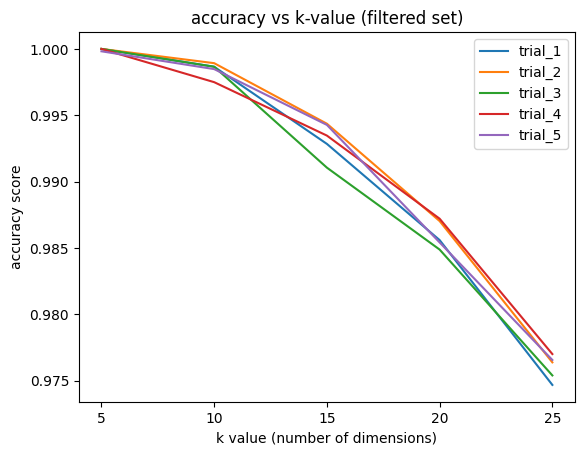

In [35]:
# plot accuracy vs k-value
for e in acc_results:
    plt.plot(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.xticks(kVals)
plt.title('accuracy vs k-value (filtered set)')
plt.show()

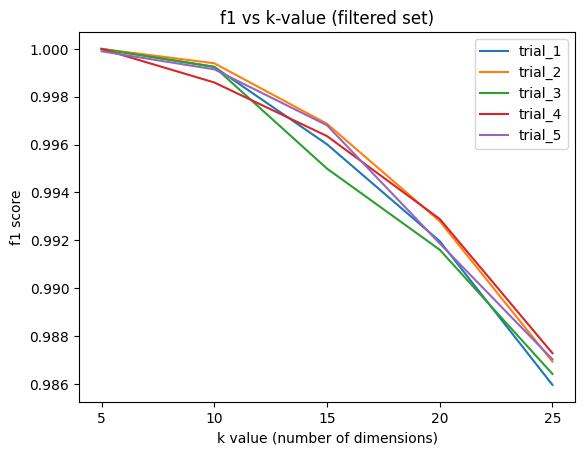

In [36]:
# plot f1 vs k_value
for e in acc_results:
    plt.plot(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.xticks(kVals)
plt.title('f1 vs k-value (filtered set)')
plt.show()

In [37]:
# include k768 this time
kVals.append(768)
for e in trials:
    acc_results[e].append(k768[e][0][0])
    f1_results[e].append(k768[e][0][1])

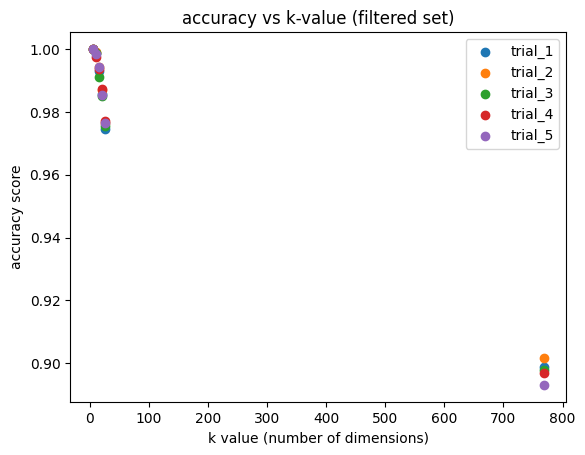

In [38]:
# plot accuracy vs k-value
for e in acc_results:
    plt.scatter(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.title('accuracy vs k-value (filtered set)')
plt.show()

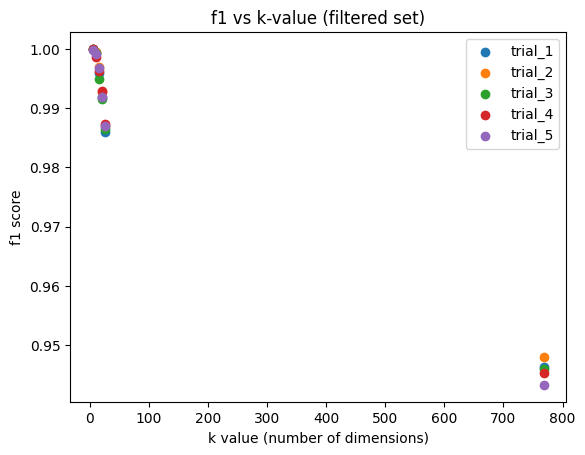

In [39]:
# plot f1 vs k_value
for e in acc_results:
    plt.scatter(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.title('f1 vs k-value (filtered set)')
plt.show()

**The data is being saved to a pickle in the next two boxes.**

Feel free to skip this if you are re-running preivous trials unless you want to overwrite the pkl file.

In [40]:
# saving kData to pickle
# kData is the collection of all the previous trials
file = open('./pickles/training_results_' + dataset + '_1.pkl', 'wb')
kData.append(k768)
kData.append(regular)
print(kData)
pickle.dump(kData, file)
file.close()

[{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_5': ((0.9998210130660462, 0.9998998397435898), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9986575979953464, 0.999250037498125), {'bad': 0, 'good': 1}), 'trial_2': ((0.9989260783962771, 0.9993994595135622), {'bad': 0, 'good': 1}), 'trial_3': ((0.9986575979953464, 0.9992504871833308), {'bad': 0, 'good': 1}), 'trial_4': ((0.9974941829246465, 0.998597334936379), {'bad': 0, 'good': 1}), 'trial_5': ((0.9984786110613926, 0.9991474850809888), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9928405226418472, 0.996011964107677), {'bad': 0, 'good': 1}), 'trial_2': ((0.9943619115804546, 0.9968701872919667), {'bad': 0, 'good': 1}), 'trial_3': ((0.9910506533023089, 0.9949964975482838), {'bad': 0, 'good': 1}), 'trial_4': ((0.9934669769106855, 0.9963552848369864), {'bad': 0, 'good': 1}), 'trial_5': ((0.9942724181

In [41]:
print(kData)

[{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_5': ((0.9998210130660462, 0.9998998397435898), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9986575979953464, 0.999250037498125), {'bad': 0, 'good': 1}), 'trial_2': ((0.9989260783962771, 0.9993994595135622), {'bad': 0, 'good': 1}), 'trial_3': ((0.9986575979953464, 0.9992504871833308), {'bad': 0, 'good': 1}), 'trial_4': ((0.9974941829246465, 0.998597334936379), {'bad': 0, 'good': 1}), 'trial_5': ((0.9984786110613926, 0.9991474850809888), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9928405226418472, 0.996011964107677), {'bad': 0, 'good': 1}), 'trial_2': ((0.9943619115804546, 0.9968701872919667), {'bad': 0, 'good': 1}), 'trial_3': ((0.9910506533023089, 0.9949964975482838), {'bad': 0, 'good': 1}), 'trial_4': ((0.9934669769106855, 0.9963552848369864), {'bad': 0, 'good': 1}), 'trial_5': ((0.9942724181

**Data from previous testing is being loaded in the next 2 cells.**

Start here if you do not wish to run all the previous trials again and simply start with k=100. 

*However, you can skip this if you ran up to this point from the beginning.*

In [22]:
# loading kData from pickle
file = open('./pickles/training_results_' + dataset + '_1.pkl', 'rb')
kData = pickle.load(file)
file.close()

<function BufferedReader.close>

In [ ]:
# re-prepping variables after loading them from 
kVals = [5, 10, 15, 20, 25]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
# removing regular from kData
regular = kData.pop()
# removing k768 from kData
# this will be added back later
k768 = kData.pop()
print(kData)

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])
        f1_results[e].append(f[e][0][1])

In [ ]:
# print graphs again to make sure the data is working
# plot accuracy vs k-value
for e in acc_results:
    plt.plot(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.xticks(kVals)
plt.title('accuracy vs k-value (filtered set)')
plt.show()

In [ ]:
# plot f1 vs k_value
for e in acc_results:
    plt.plot(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.xticks(kVals)
plt.title('f1 vs k-value (filtered set)')
plt.show()

In [ ]:
# do additional testing with k = 100, 200, 300, and 500

# no longer have this so we need it again
vax_good_mat_shape = vax_good_mat.shape
vax_ref_shape = vax_ref.shape

k = 100

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [ ]:
# ========= RUN WITH k=100 ==========
k100 = dict()

In [ ]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k100['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k100['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k100['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k100['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k100['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# print the contents of k100
print('Results of training with k=100')
for e in k100:
    print('===================')
    print(e)
    print('accuracy: ', k100[e][0][0])
    print('f1-score: ', k100[e][0][1])
    print('labels: ', k100[e][1])

In [ ]:
# save to a pickle
file = open('./pickles/k100_' + dataset + '_1.pkl', 'wb')
print(k100)
pickle.dump(k100, file)
file.close()

In [ ]:
# load data from a pickle
file = open('./pickles/k100_' + dataset + '_1.pkl', 'rb')
k100 = pickle.load(file)
file.close()

In [ ]:
# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 200

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [ ]:
# ========= RUN WITH k200 ==========
k200 = dict()

In [ ]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k200['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k200['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k200['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k200['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k200['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# print the contents of k200
print('Results of training with k=200')
for e in k200:
    print('===================')
    print(e)
    print('accuracy: ', k200[e][0][0])
    print('f1-score: ', k200[e][0][1])
    print('labels: ', k200[e][1])

In [ ]:
# save to a pickle
file = open('./pickles/k200_' + dataset + '_1.pkl', 'wb')
print(k200)
pickle.dump(k200, file)
file.close()

In [ ]:
# load data from a pickle
file = open('./pickles/k200_' + dataset + '_1.pkl', 'rb')
k200 = pickle.load(file)
file.close()

In [ ]:
# do additional testing with k = 100, 200, 300, and 500

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 300

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [ ]:
# ========= RUN WITH k=300 ==========
k300 = dict()

In [ ]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k300['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k300['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k300['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k300['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k300['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# print the contents of k300
print('Results of training with k=300')
for e in k300:
    print('===================')
    print(e)
    print('accuracy: ', k300[e][0][0])
    print('f1-score: ', k300[e][0][1])
    print('labels: ', k300[e][1])

In [ ]:
# save to a pickle
file = open('./pickles/k300_' + dataset + '_1.pkl', 'wb')
print(k300)
pickle.dump(k300, file)
file.close()

In [ ]:
# load data from a pickle
file = open('./pickles/k300_' + dataset + '_1.pkl', 'rb')
k300 = pickle.load(file)
file.close()

In [ ]:
# do additional testing with k = 100, 200, 300, and 500

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 500

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [ ]:
# ========= RUN WITH k=500 ==========
k500 = dict()

In [ ]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k500['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k500['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k500['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k500['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k500['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# print the contents of k500
print('Results of training with k=500')
for e in k500:
    print('===================')
    print(e)
    print('accuracy: ', k500[e][0][0])
    print('f1-score: ', k500[e][0][1])
    print('labels: ', k500[e][1])

In [ ]:
# save to a pickle
file = open('./pickles/k500_' + dataset + '_1.pkl', 'wb')
print(k500)
pickle.dump(k500, file)
file.close()

In [ ]:
# load data from a pickle
file = open('./pickles/k500_' + dataset + '_1.pkl', 'rb')
k500 = pickle.load(file)
file.close()

In [ ]:
# plotting again with more values this time

kVals = [5, 10, 15, 20, 25, 100, 200, 300, 500, 768]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
# kData = [k5, k10, k15, k20, k25]
kData.extend([k100, k200, k300, k500, k768])
# kData = [k5, k10, k15, k20, k25, k100, k200, k300, k500, k768]

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])

# more data prep
f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        f1_results[e].append(f[e][0][1])

In [ ]:
# plot accuracy vs k-value
for e in acc_results:
    plt.scatter(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.title('accuracy vs k-value')
plt.show()

In [ ]:
# plot f1 vs k_value
for e in acc_results:
    plt.scatter(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.title('f1 vs k-value')
plt.show()

In [ ]:
# going to try with 50 and 75 for a better looking graph

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 50

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [ ]:
# ========= RUN WITH k=50 ==========
k50 = dict()

In [ ]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k50['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k50['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k50['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k50['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k50['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# print the contents of k50
print('Results of training with k=50')
for e in k50:
    print('===================')
    print(e)
    print('accuracy: ', k50[e][0][0])
    print('f1-score: ', k50[e][0][1])
    print('labels: ', k50[e][1])

In [ ]:
# save to a pickle
file = open('./pickles/k50_' + dataset + '_1.pkl', 'wb')
print(k50)
pickle.dump(k50, file)
file.close()

In [ ]:
# load data from a pickle
file = open('./pickles/k50_' + dataset + '_1.pkl', 'rb')
k50 = pickle.load(file)
file.close()

In [ ]:
# going to try with 50 and 75 for a better looking graph
# do additional testing with k = 100, 200, 300, and 500

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 75

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [ ]:
# ========= RUN WITH k=75 ==========
k75 = dict()

In [ ]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k75['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k75['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k75['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k75['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k75['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

In [ ]:
# print the contents of k75
print('Results of training with k=75')
for e in k75:
    print('===================')
    print(e)
    print('accuracy: ', k75[e][0][0])
    print('f1-score: ', k75[e][0][1])
    print('labels: ', k75[e][1])

In [ ]:
# save to a pickle
file = open('./pickles/k75_' + dataset + '_1.pkl', 'wb')
print(k75)
pickle.dump(k75, file)
file.close()

In [ ]:
# load data from a pickle
file = open('./pickles/k75_' + dataset + '_1.pkl', 'rb')
k75 = pickle.load(file)
file.close()

In [ ]:
# plotting again with more values this time

kVals = [5, 10, 15, 20, 25, 50, 75, 100, 200, 300, 500, 768]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
# kData = [k5, k10, k15, k20, k25, k100, k200, k300, k500, k768]
kData.insert(5, k75)
# kData = [k5, k10, k15, k20, k25, k75, k100, k200, k300, k500, k768]
kData.insert(5, k50)
# kData = [k5, k10, k15, k20, k25, k50, k75, k100, k200, k300, k500, k768]

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])

# more data prep
f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        f1_results[e].append(f[e][0][1])

In [ ]:
# plot accuracy vs k-value
for e in acc_results:
    plt.scatter(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.title('accuracy vs k-value')
plt.show()

In [ ]:
# plot f1 vs k_value
for e in acc_results:
    plt.scatter(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.title('f1 vs k-value')
plt.show()

In [ ]:
# saving kData to pickle again
# kData is the collection of all the previous trials
file = open('./pickles/training_results_' + dataset + '_1.pkl', 'wb')
kData.append(k768)
kData.append(regular)
print(kData)
pickle.dump(kData, file)
file.close()